In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn
import pandas as pd
import numpy as np
import json
import random
import cv2
import os
from PIL import Image
import torch
import sys
import scipy.misc
from skimage.feature import hog
from PIL import Image
import numpy as np
sys.path.insert(0, '../')
from models.base_model import *
from models.discoGAN.discoGAN import discoGAN
from models.cycleGAN.cycleGAN import cycleGAN
from options.train_options import *
from train import *
from utils.logger import Logger

# Overview

Notebook contains some basic code used to practice the manipulation of images and to try some feature matching.

In [2]:
data_df = pd.read_json('../data/redbubble/data_dresses.json', lines=True)
dresses = []
paintings = []

for i in range(len(data_df['pictures'])):
    dresses.append('../data/redbubble/images/%s' %  (data_df['pictures'].iloc[i][2]))
    paintings.append('../data/redbubble/images/%s' %  (data_df['pictures'].iloc[i][1]))

In [3]:
#Get mask
mask_img = cv2.imread('../data/redbubble/masks/Graphic T-Shirt Dress_2.png')
mask_img_arr = ~np.array(mask_img)
nor = (lambda x: int((x - 0)//(255-0)))
mask_img_arr[mask_img_arr > 250] = 255
mask_img_arr[mask_img_arr < 40] = 0
mask_img_arr = np.vectorize(nor)(mask_img_arr)

In [4]:
def apply_mask(img, mask_img_arr):
    img = img * mask_img_arr
    new_mask = mask_img_arr.copy()
    new_mask[new_mask == 0] = 2
    new_mask[new_mask == 1] = 0
    new_mask[new_mask == 2] = 220
    img = img + new_mask
    img = (np.uint8(img))
    return img

# Manipulation of Image through Affine Transformation

In [53]:
def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = np.matrix(matrix, dtype=np.float)
    B = np.array(pb).reshape(8)

    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)



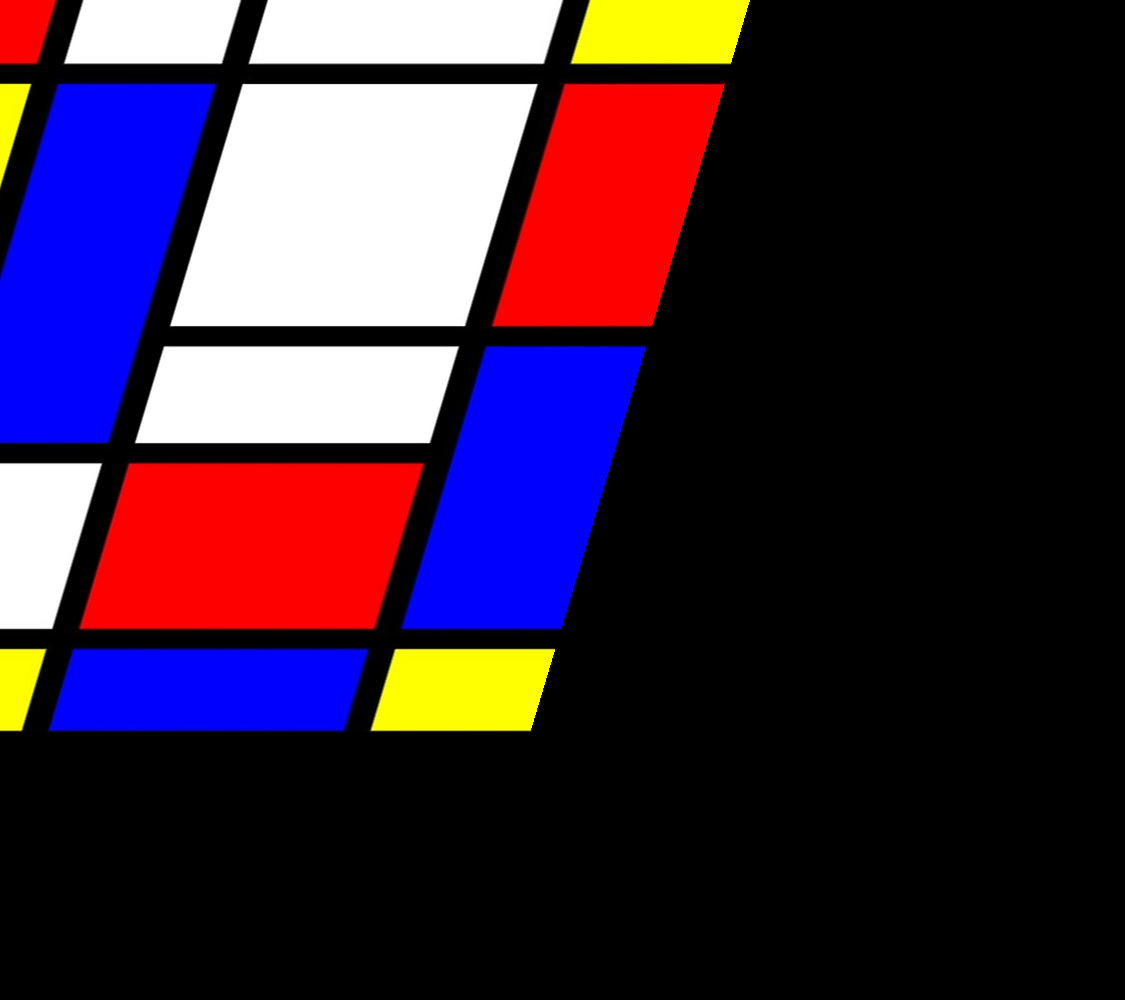

In [54]:
img = Image.open(paintings[0])
coeffs = find_coeffs(
        [(0, 0), (256, 0), (256, 256), (0, 256)],
        [(0, 0), (256, 0), (new_width, height), (xshift, height)])
width, height = img.size
m = -0.5
xshift = abs(m) * width
new_width = width + int(round(xshift))
img.transform((new_width, height), Image.AFFINE,
        coeffs, Image.BICUBIC)

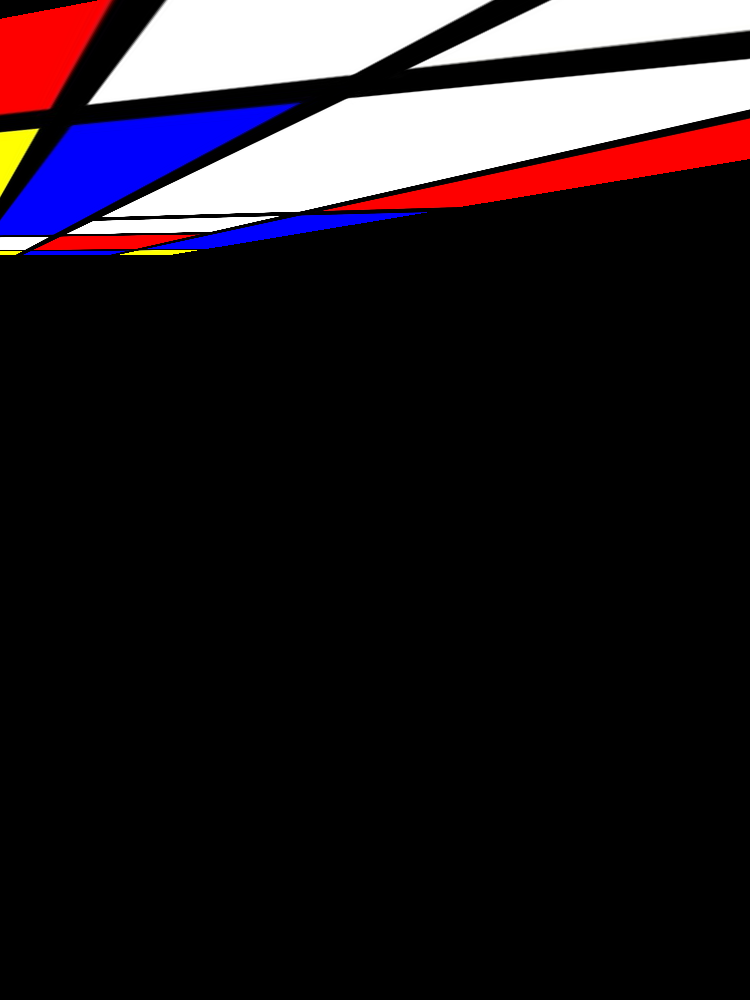

In [55]:
img = Image.open(paintings[0])
coeffs = find_coeffs(
        [(100, 0), (200, 0), (300, 256), (50, 256)],
        [(50, 0), (100, 10), (new_width, height), (xshift, height)])
width, height = img.size
m = -0.3
xshift = abs(m) * width
new_width = width + int(round(xshift))
img.transform((width, height), Image.PERSPECTIVE, coeffs,Image.BICUBIC)

# Feature Matching

## Brute Force Matching

**Unmasked:**

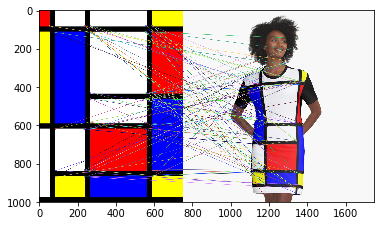

(<matplotlib.image.AxesImage at 0x7ff1b6f87710>, None)

In [57]:
img1 = cv2.imread(paintings[0]) # queryImage
img2 = cv2.imread(dresses[0])# trainImagprint

# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:100], None, flags=2)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)),plt.show()


**Masked:**

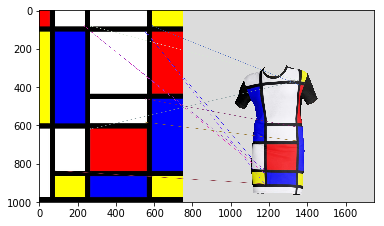

(<matplotlib.image.AxesImage at 0x7ff1b6e296d8>, None)

In [60]:
img1 = cv2.imread(paintings[0]) # queryImage
img2 = cv2.imread(dresses[0])# trainImagprint
img2 = apply_mask(img2, mask_img_arr)    
    
# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
plt.imshow(img2)
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10], None, flags=2)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)),plt.show()


## Flann Based Matching

des1  (1563, 128)
des2  (257, 128)
des1.type  float32
des2.type  float32
kp1  (1563,)
kp2  (257,)
kp1.type  object
kp2.type  object


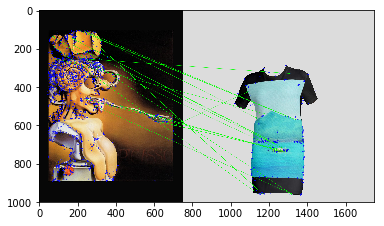

(<matplotlib.image.AxesImage at 0x7ff1b719a5c0>, None)

In [63]:
img1 = cv2.imread(paintings[100]) # queryImage
img2 = cv2.imread(dresses[600])# trainImagprint
img2 = apply_mask(img2, mask_img_arr)    
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
print('des1 ', des1.shape)
print('des2 ', des2.shape)
print('des1.type ', des1.dtype)
print('des2.type ', des2.dtype)

print('kp1 ', np.array(kp1).shape)
print('kp2 ', np.array(kp2).shape)
print('kp1.type ', np.array(kp1).dtype)
print('kp2.type ', np.array(kp2).dtype)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
        draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = 0)
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB),),plt.show()


In [11]:
print(len(matches))
print(len(kp1))
print(len(kp2))
print(matches[0])

1563
1563
257
[<DMatch 0x7fe84a9f1f50>, <DMatch 0x7fe84a9f1f30>]


In [12]:
img1_idx = matches[0][1].queryIdx
img2_idx = matches[0][1].trainIdx
print(img1_idx)
print(img2_idx)

0
56


## SIFT Based Matching

In [72]:
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(real,None)
kp2, des2 = sift.detectAndCompute(fake,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
        draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = 0)
img3 = cv2.drawMatchesKnn(real,kp1,fake,kp2,matches,None,**draw_params)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB),),plt.show()

error: OpenCV(3.4.2) /io/opencv/modules/features2d/src/draw.cpp:227: error: (-201:Incorrect size of input array) matchesMask must have the same size as matches1to2 in function 'drawMatches'


## HOG Based Matching

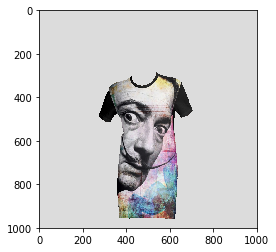

In [73]:
hog = cv2.HOGDescriptor()
img2 = apply_mask(cv2.imread(dresses[10]), mask_img_arr)
(rects, weights) = hog.detectMultiScale(img2, winStride=(4, 4),
        padding=(0, 0), scale=1.1)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB),)
plt.show()

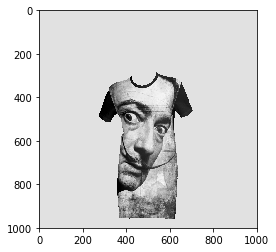

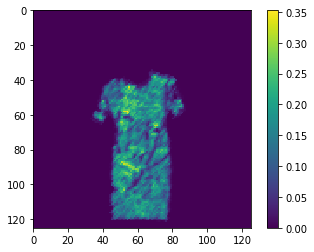

In [75]:
hog = cv2.HOGDescriptor()
h = hog.compute(img2)

img = cv2.cvtColor(img2,
                   cv2.COLOR_BGR2GRAY)

cell_size = (8, 8)  # h x w in pixels
block_size = (2, 2)  # h x w in cells
nbins = 9  # number of orientation bins

# winSize is the size of the image cropped to an multiple of the cell size
hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                  img.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
hog_feats = hog.compute(img)\
               .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], nbins) \
               .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
# hog_feats now contains the gradient amplitudes for each direction,
# for each cell of its group for each group. Indexing is by rows then columns.

gradients = np.zeros((n_cells[0], n_cells[1], nbins))

# count cells (border cells appear less often across overlapping groups)
cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

for off_y in range(block_size[0]):
    for off_x in range(block_size[1]):
        gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                  off_x:n_cells[1] - block_size[1] + off_x + 1] += \
            hog_feats[:, :, off_y, off_x, :]
        cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                   off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

# Average gradients
gradients /= cell_count

# Preview
plt.figure()
plt.imshow(img, cmap='gray')
plt.show()

bin = 5  # angle is 360 / nbins * direction
plt.pcolor(gradients[:, :, bin])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

/home/kieran/.env/thesis/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kieran/.env/thesis/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


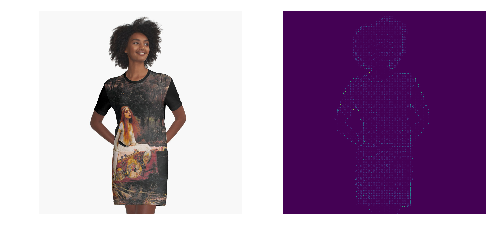

In [79]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

image = scipy.misc.imread(dresses[27])
hog_image = np.dot(image[..., :3], [0.299, 0.587, 0.144])
features, image_after_hog = hog(hog_image, orientations=9, pixels_per_cell=[8,8],
                       cells_per_block=[4,4], visualise=True, transform_sqrt=True)
axes[0].axis('off')
axes[0].imshow(image)
axes[1].axis('off')
axes[1].imshow(image_after_hog)
plt.xticks([]), plt.yticks([]) 
plt.show()
plt.draw()
path = 'hog_example.png'
fig.savefig(path)

# Analysis of results

## Comparision of fake result

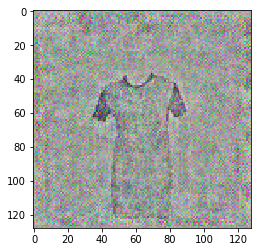

(<matplotlib.image.AxesImage at 0x7ff1b718b0f0>, None)

In [64]:
fake = cv2.imread('model/fake.png')
plt.imshow(cv2.cvtColor(fake, cv2.COLOR_BGR2RGB),),plt.show()

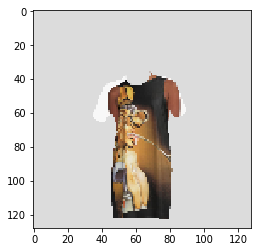

(<matplotlib.image.AxesImage at 0x7ff1b74c4940>, None)

In [66]:
real = cv2.imread(dresses[100])
real = apply_mask(real, mask_img_arr)    
real = cv2.resize(real, (128, 128))
plt.imshow(cv2.cvtColor(real, cv2.COLOR_BGR2RGB),),plt.show()

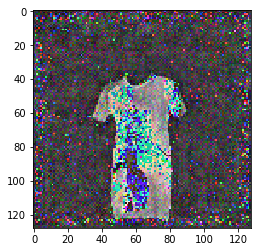

(<matplotlib.image.AxesImage at 0x7ff1b713f898>, None)

In [67]:
img3 = real - fake
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB),),plt.show()

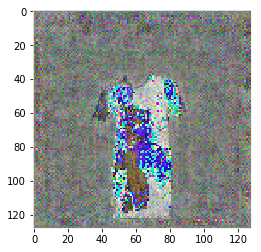

(<matplotlib.image.AxesImage at 0x7fe84a901630>, None)

In [14]:
img3 = real + fake
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB),),plt.show()

## Visualise Model

In [12]:
train_opt = TrainOptions(add_arguments=True, arguments='--which_model_netG unet128')
args = train_opt.parse_options(add_model_specfic_options('cycleGAN'))
logger =  logger = Logger(os.path.join('models', args.model), args)
print(args.which_model_netG)
model = cycleGAN(args, logger)

TypeError: __init__() got an unexpected keyword argument 'add_arguments'

In [16]:
%load_ext autoreload
from models.base_model import BaseModel
print(model)
model.load_weights('model', '690000')

loading the model from model/G_A_690000.pth
Loaded
Checking for meta data
------
module.model.model.0.weight
__patch_instance_norm_state_dict
ResnetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (3): ReLU(inplace)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (6): ReLU(inplace)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (9): ReLU(inplace)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.

AttributeError: 'ResnetGenerator' object has no attribute 'module'

## HOG Result

0_Mondrian_2.jpg
0_Mondrian_1.jpg
3_Katsushika_Hokusai_The_Great_Wave_of_Kanagawa_2.jpg
3_Katsushika_Hokusai_The_Great_Wave_of_Kanagawa_1.jpg
7_Irises_In_Monets_Garden_At_GivernyClaude_Monet_2.jpg
7_Irises_In_Monets_Garden_At_GivernyClaude_Monet_1.jpg


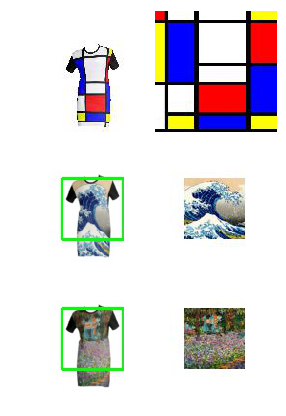

In [100]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(4, 6))
plt.rcParams["axes.edgecolor"] = "15"

image_files = [f for f in os.listdir("../data/hog_viz") if "_2.jpg" in f]

count = 0

# reshape to 2d
for file in image_files:
    split_loc = file.split('_')
    img2_path = "_".join(split_loc[0:len(split_loc) -1]) + "_1.jpg"
    
    print(file)
    print(img2_path)
    img1 = Image.open(os.path.join("../data/hog_viz",file))
    img2 = Image.open(os.path.join("../data/hog_viz",img2_path))
       
    img1 = img1.resize((128, 128), Image.ANTIALIAS)
    img2 = img2.resize((128, 128), Image.ANTIALIAS)
    
    axes[count, 1].axis('off')
    axes[count, 1].imshow(img2)
    axes[count, 0].axis('off')
    axes[count, 0].imshow(img1)
    
    count += 1
    
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.0)
plt.show()
plt.draw()

path = 'saved_figures/hog_display.png'
fig.savefig(path, dpi=200)

## FashionNet Result

In [88]:
def get_dress_painting(df, loc, index):
    name = df['file_name'][index]
    dress = Image.open(os.path.join(loc, name))
    
    name_split  = name.split('_')
    painting_name = '_'.join(name_split[0:len(name_split)-1]) + '_1.jpg'
    painting = Image.open(os.path.join(loc, painting_name))
    
    c = [int(df['x1'][index]), int(df['x2'][index]), int(df['y1'][index]), int(df['y2'][index])]
    
    #scale
    painting = painting.resize((dress.height, dress.width)) #TODO check resize for SIFT and HOG

    array = np.linspace(1, 1, painting.width * painting.height * 3)
    mat = np.reshape(array, (painting.height, painting.width, 3))
    white_background = Image.fromarray(np.uint8(mat * 255))

    painting_copy = white_background.copy()
    painting = painting.resize((abs(c[1] - c[0]) , abs(c[3] - c[2])))
    position = (c[0], c[2])
    painting_copy.paste(painting, position)
    
    #draw
    dress = np.array(dress)
    dress = dress[:, :, ::-1].copy()
    #painting_copy.rectangle((c[0], c[2]), ((c[1], c[3])), fill="green")
    cv2.rectangle(dress, (c[0], c[2]), (c[1], c[3]), (0, 255, 0), thickness=30)
    dress = cv2.cvtColor(dress, cv2.COLOR_BGR2RGB)
    dress = Image.fromarray(dress)
    return dress, painting_copy

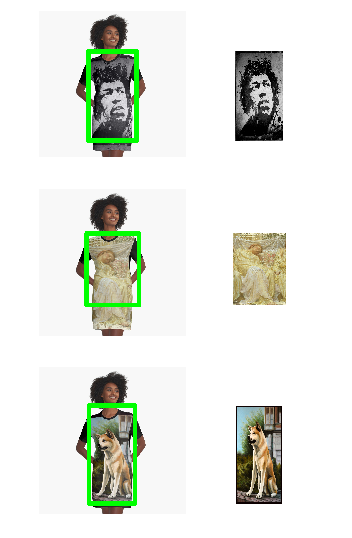

In [99]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(5, 8))
plt.rcParams["axes.edgecolor"] = "15"
df = pd.read_csv('../data/FN_bb.csv')
data_set_loc = '../data/redbubble/images/'
dress1, painting1 = get_dress_painting(df, data_set_loc, 1865)
dress2, painting2 = get_dress_painting(df, data_set_loc, 10)
dress3, painting3 = get_dress_painting(df, data_set_loc, 742)

dresses = [dress1, dress2, dress3]
paintings = [painting1, painting2, painting3]

for i in range(len(dresses)):
    
    axes[i, 1].axis('off')
    axes[i, 1].imshow(paintings[i])
    axes[i, 0].axis('off')
    axes[i, 0].imshow(dresses[i])
    count += 1
    
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.0)
plt.show()
plt.draw()

path = 'saved_figures/fashionNet_display.png'
fig.savefig(path, dpi=200)